In [1]:
### If testing, data is randomly generated, and plots are not saved.
### For performing the analysis with actual data, set TEST = False.
TEST = True 

Figure 1C: Variation of EMA variables explained by the estimated VAR(1) models.

Figure 1D: Correlation of predicted and observed proximal effects of inputs on EMA variables.

1-step ahead prediction: across-subject mean R^2=0.9354128192342961, std=0.046216993268727954
Empirical vs. predicted EMI effects: r=0.9990707793000744, p=6.579741515637158e-81, R^2=0.9981424220512579


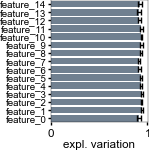

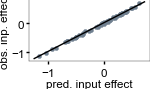

In [2]:
from ctrl import utils
from ctrl.discrete_optimal_control import LQR
import custom_rcparams_paper as crc
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import sem
import os

if TEST:
    data = utils.generate_random_dataset(10, 50)
else:
    data = utils.load_data()
    os.makedirs('figures', exist_ok=True)

N = len(data)
n_feat = len(data[0]['Xlabs'])
n_emis = len(data[0]['Ilabs'])
determination_coeff = np.zeros((N, n_feat))
r_squared = np.zeros((N, n_feat))
emi_effects = np.zeros((N, n_emis, n_feat))
predicted_effects = np.zeros((N, n_emis, n_feat))
Xpred = []

for j in range(len(data)):
    A = data[j]['A']
    B = data[j]['B']
    X = data[j]['X']
    Xnan = data[j]['Xnan']
    U = data[j]['Inp']

    prediction = LQR.step(A, B, X, U)[:-1]  # Make a 1-step ahead prediction with the model
    Xpred.append(prediction)
    mask = np.isnan(Xnan[:-1])              # We only analyze the data which is not missing (leaving out imputed data)
    prediction[mask] = np.nan

    ### For figure 1C: Explained variance of the trajectory
    determination_coeff[j] = 1 - (np.nansum((prediction - Xnan[1:])**2, axis=0) 
                                  / np.nansum((np.nanmean(Xnan[1:], axis=0, keepdims=True) - Xnan[1:])**2, axis=0))

    ### For figure 1D: Predicted and empirical proximal effects of EMI
    ### The proximal effect if the difference between the EMA values before and after an EMI.
    for e in range(n_emis):
        Xnan_before = Xnan[:-1][U[:-1,e]==1]
        Xnan_after = Xnan[1:][U[:-1,e]==1]
        emi_effects[j,e] = np.nanmean(Xnan_after - Xnan_before, axis=0)
        predicted_after = prediction[U[:-1,e]==1]
        predicted_effects[j,e] = np.nanmean((predicted_after - Xnan_before), axis=0)

    for f in range(n_feat):
        mask = ~np.isnan(Xnan[1:][:,f]) & ~np.isnan(prediction[:,f])
        r_squared[j,f] = np.corrcoef(prediction[mask,f], Xnan[1:][mask, f])[0,1]**2

with mpl.rc_context({'ytick.labelsize':'x-small'}):
    fig, ax = plt.subplots(1,1, figsize=(1.5,1.5))
    ax.barh(range(n_feat), np.nanmean(r_squared, axis=0), color=crc.colors.features,
                xerr=sem(r_squared, axis=0, nan_policy='omit'), error_kw={'linewidth':1}, ecolor=crc.colors.errorbars)
    ax.set_yticks(np.arange(n_feat), labels=data[0]['Xlabs'])
    ax.set_ylim((-0.5, n_feat-0.5))
    ax.set_xlabel('expl. variation')
    if not TEST:
        fig.savefig('figures/figure1C.png')


fig, ax = plt.subplots(1,1,figsize=(1.5,0.9))
predicted_effects[np.isnan(emi_effects)] = np.nan
predicted_effects = np.nanmean(predicted_effects, axis=0)
emi_effects = np.nanmean(emi_effects, axis=0)
ax, corr = utils.plot_regression(predicted_effects.flatten(), emi_effects.flatten(), 
                      scatter_kwargs={'color':crc.colors.standard}, line_kwargs={'color':'k'}, ax=ax,
                      nan_policy='omit')
ax.set_xlabel('pred. input effect')
ax.set_ylabel('obs. inp. effect')
if not TEST:
    fig.savefig('figures/figure1D.png')
    fig.savefig('figures/figure1D.svg')

print(f"1-step ahead prediction: across-subject mean R^2={np.nanmean(r_squared)}, std={np.nanstd(r_squared)}")
print(f'Empirical vs. predicted EMI effects: r={corr.statistic}, p={corr.pvalue}, R^2={corr.statistic**2}')